In [1]:
## import libraries 
import os, sys 
import argparse
import glob 
import pathlib
import time 
import pickle 
import json 

import numpy as np
import scipy as sp
import scipy.optimize as scopt
import scipy.interpolate as interpolate

import matplotlib
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.plasma(np.linspace(0.9,0.0,5)))

titlefontsize = 18
labelfontsize = 18
legendfontsize = 14
labelpad = 15

savedir = "./"

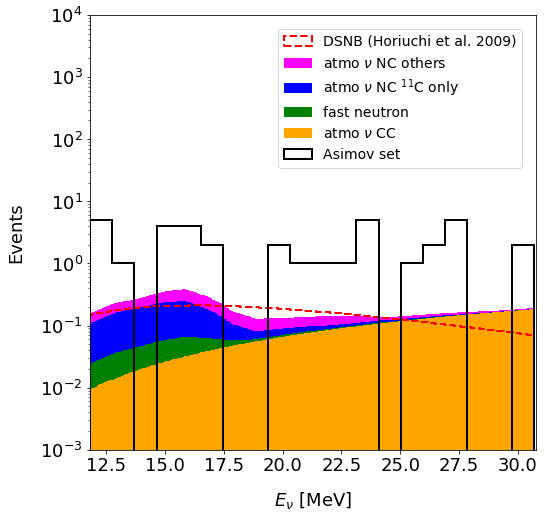

In [37]:
## check numpy file 
finname = "./data/arr_enu.npz"
fin = np.load(finname)
enu = fin["enu"]

finname = "./data/arr_n_ls.npz"
fin = np.load(finname)
n_sig_ls = fin["n_arr_ls"][0]
n_fastn_ls = fin["n_arr_ls"][1]
n_atmo_nu_cc_ls = fin["n_arr_ls"][2]
n_atmo_nu_nc_11C_ls = fin["n_arr_ls"][3]
n_atmo_nu_nc_others_ls = fin["n_arr_ls"][4]

finname = "./data/arr_pdf_ls.npz"
fin = np.load(finname)
pdf_sig_ls = fin["pdf_sig_ls"]
pdf_fastn_ls = fin["pdf_fastn_ls"]
pdf_atmo_nu_cc_ls = fin["pdf_atmo_nu_cc_ls"] 
pdf_atmo_nu_nc_11C_ls = fin["pdf_atmo_nu_nc_11C_ls"]
pdf_atmo_nu_nc_others_ls = fin["pdf_atmo_nu_nc_others_ls"]

finname = "./data/arr_asimov_ls.npz"
fin = np.load(finname)
asimov_set_ls = fin["asimov_set_ls"]


bincenters = 0.5*(enu[1:]+enu[:-1])

fig, ax = plt.subplots(1, 1, figsize=(8,8)) 

wgt = n_sig_ls*pdf_sig_ls[:-1]
ax.hist(bincenters, weights=wgt, bins=enu, range=[np.min(enu),np.max(enu)], 
           histtype="step", linestyle="dashed", linewidth=2.0, color="red", label=r"DSNB (Horiuchi et al. 2009)")

wgt = n_fastn_ls*pdf_fastn_ls[:-1] + n_atmo_nu_cc_ls*pdf_atmo_nu_cc_ls[:-1] + n_atmo_nu_nc_11C_ls*pdf_atmo_nu_nc_11C_ls[:-1] + n_atmo_nu_nc_others_ls*pdf_atmo_nu_nc_others_ls[:-1]
ax.hist(bincenters, weights=wgt, bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="magenta", label=r"atmo $\nu$ NC others")
wgt = n_fastn_ls*pdf_fastn_ls[:-1] + n_atmo_nu_cc_ls*pdf_atmo_nu_cc_ls[:-1] + n_atmo_nu_nc_11C_ls*pdf_atmo_nu_nc_11C_ls[:-1] 
ax.hist(bincenters, weights=wgt, bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="blue", label=r"atmo $\nu$ NC $^{11}$C only")
wgt = n_fastn_ls*pdf_fastn_ls[:-1] + n_atmo_nu_cc_ls*pdf_atmo_nu_cc_ls[:-1] 
ax.hist(bincenters, weights=wgt, bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="green", label=r"fast neutron")
wgt = n_atmo_nu_cc_ls*pdf_atmo_nu_cc_ls[:-1] 
ax.hist(bincenters, weights=wgt, bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="orange", label=r"atmo $\nu$ CC")

#ax.hist(asimov_set_ls, weights=0.01*np.ones(len(asimov_set_ls)), bins=enu, range=[np.min(enu),np.max(enu)], 
#           histtype="step", linestyle="solid", linewidth=2.0, color="black", label=r"Asimov set ($\times100$)")

enu_rough = np.linspace(np.min(enu), np.max(enu), 21)
ax.hist(asimov_set_ls, weights=np.ones(len(asimov_set_ls)), bins=enu_rough, range=[np.min(enu),np.max(enu)], 
           histtype="step", linestyle="solid", linewidth=2.0, color="black", label=r"Asimov set")


ax.set_xlabel(r"$E_{\nu}$ [MeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"Events", fontsize=labelfontsize, labelpad=labelpad)
ax.set_xlim(11.789,30.789) 
ax.set_ylim(1.0e-3,1.0e+4)
ax.set_yscale("log")

ax.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize)
plt.tick_params(labelsize=labelfontsize)
plt.subplots_adjust(wspace=0, hspace=0.05)




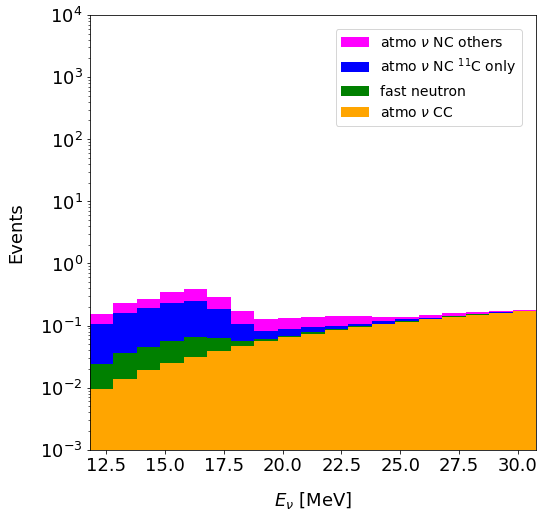

In [24]:
## JUNO
finname = "./data/bkg_juno_fv1.dat"
fin = open(finname, "r")

enu = [] 
fastn = [] 
cc = [] 
nc_c11only = [] 
nc_noc11 = [] 

data = fin.readlines()
for i, idata in enumerate(data):
    idata = idata.split()
    
    enu.append(float(idata[0]))
    fastn.append(float(idata[1]))
    cc.append(float(idata[2]))
    nc_c11only.append(float(idata[3]))
    nc_noc11.append(float(idata[4]))

enu = np.array(enu, dtype=float)
enu += 0.789 
bincenters = 0.5*(enu[1:]+enu[:-1])
fastn = np.array(fastn, dtype=float)
cc = np.array(cc, dtype=float)
nc_c11only = np.array(nc_c11only, dtype=float)
nc_noc11 = np.array(nc_noc11, dtype=float)


fig, ax = plt.subplots(1, 1, figsize=(8,8)) 

ax.hist(bincenters, weights=fastn[:-1]+cc[:-1]+nc_c11only[:-1]+nc_noc11[:-1], bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="magenta", label=r"atmo $\nu$ NC others")
ax.hist(bincenters, weights=fastn[:-1]+cc[:-1]+nc_c11only[:-1], bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="blue", label=r"atmo $\nu$ NC $^{11}$C only")
ax.hist(bincenters, weights=fastn[:-1]+cc[:-1], bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="green", label=r"fast neutron")
ax.hist(bincenters, weights=cc[:-1], bins=enu, range=[np.min(enu),np.max(enu)], 
           linestyle="solid", linewidth=3.0, color="orange", label=r"atmo $\nu$ CC")


ax.set_xlabel(r"$E_{\nu}$ [MeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"Events", fontsize=labelfontsize, labelpad=labelpad)
ax.set_xlim(11.789,30.789) 
ax.set_ylim(1.0e-3,1.0e+4)
ax.set_yscale("log")

ax.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize)
plt.tick_params(labelsize=labelfontsize)
plt.subplots_adjust(wspace=0, hspace=0.05)

In [44]:
## PDF inputs  
"""
 KamLAND 
"""
finname = "./pdf/KamLAND/EnergySpectrum-Background.txt"
fin = open(finname, "r")

enu_bin_mid = []
enu_bin_low = []
enu_bin_high = []
pdf_fastn = [] 
pdf_atmo_cc = [] 
pdf_atmo_nc = [] 
pdf_acc = [] 
pdf_spall = [] 
pdf_reac = [] 

data = fin.readlines()
for i, idata in enumerate(data):
    idata = idata.split()
    print(idata)
    
    if i > 0: 
        enu_bin_mid.append(float(idata[0]))
        enu_bin_low.append(float(idata[1]))
        enu_bin_high.append(float(idata[2]))
        pdf_fastn.append(float(idata[3]))
        pdf_atmo_cc.append(float(idata[4]))
        pdf_atmo_nc.append(float(idata[5]))
        pdf_acc.append(float(idata[6]))
        pdf_spall.append(float(idata[7]))
        pdf_reac.append(float(idata[8]))

enu_bin_mid = np.array(enu_bin_mid, dtype=float)
enu_bin_low = np.array(enu_bin_low, dtype=float)
enu_bin_high = np.array(enu_bin_high, dtype=float)
pdf_fastn = np.array(pdf_fastn, dtype=float) 
pdf_atmo_cc = np.array(pdf_atmo_cc, dtype=float)
pdf_atmo_nc = np.array(pdf_atmo_nc, dtype=float)
pdf_acc = np.array(pdf_acc, dtype=float)
pdf_spall = np.array(pdf_spall, dtype=float)
pdf_reac = np.array(pdf_reac, dtype=float)

pdf_kamland = {"enu_bin_mid": enu_bin_mid, 
                        "enu_bin_low": enu_bin_low, 
                        "enu_bin_high": enu_bin_high, 
                        "pdf_fastn": pdf_fastn, 
                        "pdf_atmo_cc": pdf_atmo_cc, 
                        "pdf_atmo_nc": pdf_atmo_nc, 
                        "pdf_acc": pdf_acc, 
                        "pdf_spall": pdf_spall, 
                        "pdf_reac": pdf_reac
                        }


"""
 Super-K 
"""



['#', 'E_Mean', 'E_Lower', 'E_Upper', 'FastNeutron', 'AtmosphericCC', 'AtmosphericNC', 'Accidental', 'Spallation', 'Reactor']
['7.55', '7.50', '7.60', '0.1449', '0.0312', '0.4573', '0.0115', '2.7276', '3.5989']
['7.65', '7.60', '7.70', '0.1449', '0.0313', '0.4575', '0.0400', '2.6426', '2.6341']
['7.75', '7.70', '7.80', '0.1449', '0.0315', '0.4577', '0.0415', '2.5571', '1.9189']
['7.85', '7.80', '7.90', '0.1449', '0.0317', '0.4579', '0.0675', '2.4713', '1.3944']
['7.95', '7.90', '8.00', '0.1449', '0.0318', '0.4580', '0.0195', '2.3853', '1.0119']
['8.05', '8.00', '8.10', '0.1449', '0.0320', '0.4582', '0.0110', '2.2990', '0.7346']
['8.15', '8.10', '8.20', '0.1449', '0.0322', '0.4584', '0.0305', '2.2123', '0.5352']
['8.25', '8.20', '8.30', '0.1449', '0.0323', '0.4586', '0.0395', '2.1251', '0.3927']
['8.35', '8.30', '8.40', '0.1449', '0.0325', '0.4588', '0.0300', '2.0371', '0.2908']
['8.45', '8.40', '8.50', '0.1449', '0.0327', '0.4590', '0.0315', '1.9482', '0.2174']
['8.55', '8.50', '8.60',

'\n Super-K \n'

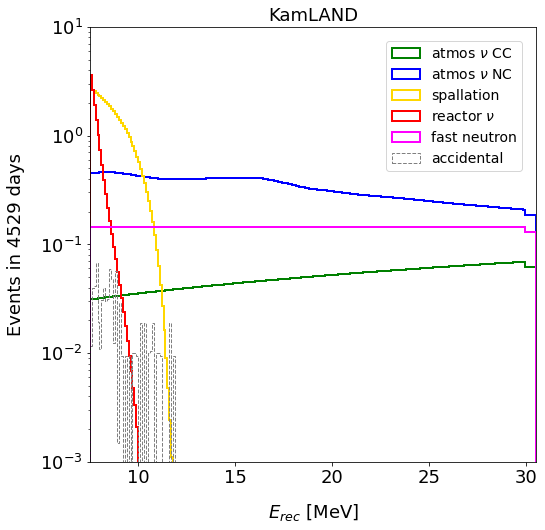

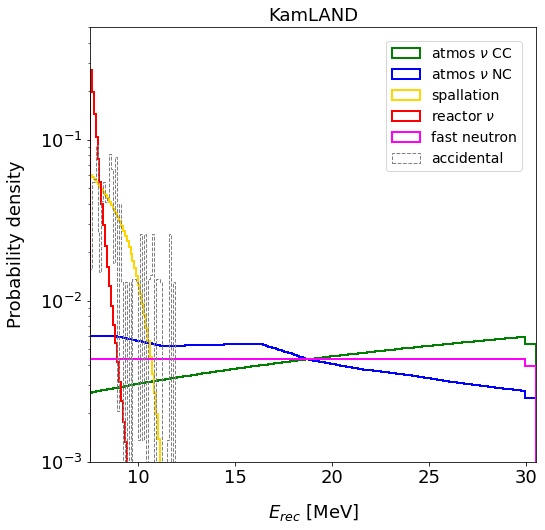

In [45]:
## plot KamLAND PDFs 
fig, ax = plt.subplots(1, 1, figsize=(8,8))

enu_bins = pdf_kamland["enu_bin_low"]
enu_bins = np.append(enu_bins, pdf_kamland["enu_bin_high"][-1])
bincenters = pdf_kamland["enu_bin_mid"]

wgt = pdf_kamland["pdf_atmo_cc"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"atmos $\nu$ CC", histtype="step", linestyle="solid", linewidth=2.0, color="green")
wgt = pdf_kamland["pdf_atmo_nc"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"atmos $\nu$ NC", histtype="step", linestyle="solid", linewidth=2.0, color="blue")
wgt = pdf_kamland["pdf_spall"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"spallation", histtype="step", linestyle="solid", linewidth=2.0, color="gold")
wgt = pdf_kamland["pdf_reac"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"reactor $\nu$", histtype="step", linestyle="solid", linewidth=2.0, color="red")
wgt = pdf_kamland["pdf_fastn"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"fast neutron", histtype="step", linestyle="solid", linewidth=2.0, color="magenta")
wgt = pdf_kamland["pdf_acc"]
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"accidental", histtype="step", linestyle="dashed", linewidth=1.0, color="grey")

ax.set_xlim(enu_bins[0],enu_bins[-1])
ax.set_ylim(1.0e-3, 10)
ax.set_yscale("log")

ax.set_title(r"KamLAND", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{rec}$ [MeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"Events in 4529 days", fontsize=labelfontsize, labelpad=labelpad)

plt.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize)
plt.tick_params(labelsize=labelfontsize)
plt.savefig(f"{savedir}/kamland_fitted.png", format="png", dpi=300, bbox_inches="tight")



fig, ax = plt.subplots(1, 1, figsize=(8,8))

enu_bins = pdf_kamland["enu_bin_low"]
enu_bins = np.append(enu_bins, pdf_kamland["enu_bin_high"][-1])
bincenters = pdf_kamland["enu_bin_mid"]

wgt = pdf_kamland["pdf_atmo_cc"]/np.sum(pdf_kamland["pdf_atmo_cc"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"atmos $\nu$ CC", histtype="step", linestyle="solid", linewidth=2.0, color="green")
wgt = pdf_kamland["pdf_atmo_nc"]/np.sum(pdf_kamland["pdf_atmo_nc"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"atmos $\nu$ NC", histtype="step", linestyle="solid", linewidth=2.0, color="blue")
wgt = pdf_kamland["pdf_spall"]/np.sum(pdf_kamland["pdf_spall"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"spallation", histtype="step", linestyle="solid", linewidth=2.0, color="gold")
wgt = pdf_kamland["pdf_reac"]/np.sum(pdf_kamland["pdf_reac"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"reactor $\nu$", histtype="step", linestyle="solid", linewidth=2.0, color="red")
wgt = pdf_kamland["pdf_fastn"]/np.sum(pdf_kamland["pdf_fastn"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"fast neutron", histtype="step", linestyle="solid", linewidth=2.0, color="magenta")
wgt = pdf_kamland["pdf_acc"]/np.sum(pdf_kamland["pdf_acc"])
ax.hist(bincenters, weights=wgt, bins=enu_bins, range=[enu_bins[0],enu_bins[-1]], 
           label=r"accidental", histtype="step", linestyle="dashed", linewidth=1.0, color="grey")

ax.set_xlim(enu_bins[0],enu_bins[-1])
ax.set_ylim(1.0e-3, 0.5)
ax.set_yscale("log")

ax.set_title(r"KamLAND", fontsize=titlefontsize)
ax.set_xlabel(r"$E_{rec}$ [MeV]", fontsize=labelfontsize, labelpad=labelpad)
ax.set_ylabel(r"Probability density", fontsize=labelfontsize, labelpad=labelpad)

plt.legend(bbox_to_anchor=(1,1), loc="upper right", borderaxespad=1, fontsize=legendfontsize)
plt.tick_params(labelsize=labelfontsize)
plt.savefig(f"{savedir}/kamland_pdf.png", format="png", dpi=300, bbox_inches="tight")